<a href="https://colab.research.google.com/github/ChaerinKim12/codetree-TILs/blob/main/Mission02_%EC%B1%84%EB%A6%B0_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# =============================================================================
# 셸 1: 환경 설정 및 라이브러리 설치
# =============================================================================

# GPU 확인 및 필요 라이브러리 설치
!nvidia-smi
!pip install opencv-python seaborn

# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torch.cuda.amp import autocast, GradScaler

import json
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import warnings
warnings.filterwarnings('ignore')

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 중인 장치: {device}")
if device.type == 'cuda':
    print(f"GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"GPU 이름: {torch.cuda.get_device_name(0)}")

print("환경 설정 완료!")
print("다음: 데이터 경로 설정 (셸 2)")

Wed Sep 10 12:13:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# =============================================================================
# 셸 2: 데이터 경로 설정 및 확인
# =============================================================================

import os
import zipfile

# 데이터 경로 설정 (본인의 드라이브 경로에 맞게 수정하세요)
TRAIN_IMG_DIR = "/content/drive/MyDrive/dataset_mission2/HeightEstimation/images/train"
VALID_IMG_DIR = "/content/drive/MyDrive/dataset_mission2/HeightEstimation/images/valid"
TRAIN_JSON_PATH = "/content/drive/MyDrive/dataset_mission2/HeightEstimation/labels/train"
VALID_JSON_PATH = "/content/drive/MyDrive/dataset_mission2/HeightEstimation/labels/valid"

# 체크포인트 저장 경로
CHECKPOINT_DIR = "/content/drive/MyDrive/dataset_mission2/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# 경로 존재 확인
paths_to_check = [TRAIN_IMG_DIR, VALID_IMG_DIR, TRAIN_JSON_PATH, VALID_JSON_PATH]
for path in paths_to_check:
    if os.path.exists(path):
        print(f"✅ 경로 존재: {path}")
    else:
        print(f"❌ 경로 없음: {path}")

# 모든 폴더에서 ZIP 파일 찾아서 압축 해제하는 함수
def extract_zip_files(directory, description):
    """지정된 디렉토리에서 모든 ZIP 파일을 찾아 압축 해제"""
    print(f"\n{description} 폴더 내용 확인:")

    if not os.path.exists(directory):
        print(f"❌ 폴더가 존재하지 않습니다: {directory}")
        return

    items = os.listdir(directory)
    for item in items:
        print(f"  - {item}")

    # ZIP 파일 찾기 및 압축 해제
    zip_files = [item for item in items if item.endswith('.zip')]

    if not zip_files:
        print(f"  압축 파일이 없습니다.")
        return

    for zip_file in zip_files:
        zip_path = os.path.join(directory, zip_file)
        print(f"\n압축 파일 발견: {zip_file}")
        print("압축 해제 중...")

        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(directory)
            print(f"✅ {zip_file} 압축 해제 완료!")

        except Exception as e:
            print(f"❌ {zip_file} 압축 해제 실패: {e}")

# 모든 디렉토리에서 ZIP 파일 압축 해제
directories_to_extract = [
    (TRAIN_IMG_DIR, "Train images"),
    (VALID_IMG_DIR, "Valid images"),
    (TRAIN_JSON_PATH, "Train labels"),
    (VALID_JSON_PATH, "Valid labels")
]

for directory, description in directories_to_extract:
    extract_zip_files(directory, description)

print("\n" + "="*60)
print("압축 해제 후 최종 데이터셋 확인")
print("="*60)

# 압축 해제 후 파일 개수 확인
try:
    train_imgs = len([f for f in os.listdir(TRAIN_IMG_DIR) if f.endswith(('.jpg', '.png', '.jpeg'))])
    valid_imgs = len([f for f in os.listdir(VALID_IMG_DIR) if f.endswith(('.jpg', '.png', '.jpeg'))])
    train_jsons = len([f for f in os.listdir(TRAIN_JSON_PATH) if f.endswith('.json')])
    valid_jsons = len([f for f in os.listdir(VALID_JSON_PATH) if f.endswith('.json')])

    print(f"📊 데이터셋 통계:")
    print(f"  Train images: {train_imgs}개")
    print(f"  Valid images: {valid_imgs}개")
    print(f"  Train labels: {train_jsons}개 JSON 파일")
    print(f"  Valid labels: {valid_jsons}개 JSON 파일")

    # 데이터 무결성 확인
    if train_imgs > 0 and valid_imgs > 0 and train_jsons > 0 and valid_jsons > 0:
        print("\n✅ 모든 데이터 파일이 정상적으로 확인되었습니다!")

        # 이미지와 라벨 수가 일치하는지 확인
        if train_imgs == train_jsons and valid_imgs == valid_jsons:
            print("✅ 이미지와 라벨 파일 수가 일치합니다!")
        else:
            print("⚠️ 이미지와 라벨 파일 수가 일치하지 않습니다.")
            print(f"   Train: images({train_imgs}) vs labels({train_jsons})")
            print(f"   Valid: images({valid_imgs}) vs labels({valid_jsons})")
    else:
        print("\n❌ 일부 데이터 파일이 누락되었습니다. 경로를 확인해주세요.")

except Exception as e:
    print(f"❌ 데이터 확인 중 오류: {e}")

print("\n🎯 다음: JSON 데이터 로딩 및 분석 (셸 3)")

✅ 경로 존재: /content/drive/MyDrive/dataset_mission2/HeightEstimation/images/train
✅ 경로 존재: /content/drive/MyDrive/dataset_mission2/HeightEstimation/images/valid
✅ 경로 존재: /content/drive/MyDrive/dataset_mission2/HeightEstimation/labels/train
✅ 경로 존재: /content/drive/MyDrive/dataset_mission2/HeightEstimation/labels/valid

Train images 폴더 내용 확인:
  - TS_KS.zip

압축 파일 발견: TS_KS.zip
압축 해제 중...
✅ TS_KS.zip 압축 해제 완료!

Valid images 폴더 내용 확인:
  - VS_KS.zip

압축 파일 발견: VS_KS.zip
압축 해제 중...
✅ VS_KS.zip 압축 해제 완료!

Train labels 폴더 내용 확인:
  - TL_KS_LINE.zip

압축 파일 발견: TL_KS_LINE.zip
압축 해제 중...
✅ TL_KS_LINE.zip 압축 해제 완료!

Valid labels 폴더 내용 확인:
  - K3A_CHN_20170723050144_3.json
  - K3A_CHN_20170423052236_3.json
  - K3A_CHN_20170123052151_14.json
  - K3A_CHN_20170423052236_20.json
  - K3A_CHN_20170723050144_28.json
  - K3A_CHN_20181002045733_16.json
  - K3A_CHN_20190801050257_34.json
  - K3A_CHN_20180328050206_3.json
  - K3A_CHN_20180809050333_43.json
  - K3A_CHN_20180809050333_12.json
  - K3A_CHN_2017012305

In [4]:
# =============================================================================
# 셸 3: 최소한의 JSON 로딩 (빠른 버전)
# =============================================================================

def load_json_data(json_dir):
    """JSON 파일들을 하나로 합치기"""
    all_data = {}
    json_files = [f for f in os.listdir(json_dir) if f.endswith('.json')]

    print(f"로딩할 JSON 파일: {len(json_files)}개")

    for i, json_file in enumerate(json_files):
        if i % 100 == 0:  # 진행상황 출력
            print(f"진행중... {i}/{len(json_files)}")

        file_path = os.path.join(json_dir, json_file)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                all_data.update(data)
        except Exception as e:
            print(f"에러 ({json_file}): {e}")

    return all_data

# JSON 데이터 로딩
print("Train JSON 로딩...")
train_labels = load_json_data(TRAIN_JSON_PATH)
print(f"Train 완료: {len(train_labels)}개")

print("\nValid JSON 로딩...")
valid_labels = load_json_data(VALID_JSON_PATH)
print(f"Valid 완료: {len(valid_labels)}개")

# 샘플 1개만 확인
sample_key = list(train_labels.keys())[0]
sample = train_labels[sample_key]
print(f"\n샘플 확인:")
print(f"- 파일명: {sample['filename']}")
print(f"- 굴뚝 수: {len(sample['regions'])}개")
print(f"- 첫 굴뚝 높이: {sample['regions'][0]['region_attributes']['chi_height_m']}m")

print(f"\nJSON 로딩 완료! 다음: Dataset 클래스 (셸 4)")

Train JSON 로딩...
로딩할 JSON 파일: 8052개
진행중... 0/8052
진행중... 100/8052
진행중... 200/8052
진행중... 300/8052
진행중... 400/8052
진행중... 500/8052
진행중... 600/8052
진행중... 700/8052
진행중... 800/8052
진행중... 900/8052
진행중... 1000/8052
진행중... 1100/8052
진행중... 1200/8052
진행중... 1300/8052
진행중... 1400/8052
진행중... 1500/8052
진행중... 1600/8052
진행중... 1700/8052
진행중... 1800/8052
진행중... 1900/8052
진행중... 2000/8052
진행중... 2100/8052
진행중... 2200/8052
진행중... 2300/8052
진행중... 2400/8052
진행중... 2500/8052
진행중... 2600/8052
진행중... 2700/8052
진행중... 2800/8052
진행중... 2900/8052
진행중... 3000/8052
진행중... 3100/8052
진행중... 3200/8052
진행중... 3300/8052
진행중... 3400/8052
진행중... 3500/8052
진행중... 3600/8052
진행중... 3700/8052
진행중... 3800/8052
진행중... 3900/8052
진행중... 4000/8052
진행중... 4100/8052
진행중... 4200/8052
진행중... 4300/8052
진행중... 4400/8052
진행중... 4500/8052
진행중... 4600/8052
진행중... 4700/8052
진행중... 4800/8052
진행중... 4900/8052
진행중... 5000/8052
진행중... 5100/8052
진행중... 5200/8052
진행중... 5300/8052
진행중... 5400/8052
진행중... 5500/8052
진행중... 5600/8052
진행중... 

In [5]:
# =============================================================================
# 셸 4: 개선된 Dataset 클래스 (JSON 구조 최대 활용)
# =============================================================================

class ImprovedChimneyDataset(Dataset):
    def __init__(self, image_dir, labels_dict, transform=None, use_metadata=True):
        self.image_dir = image_dir
        self.labels_dict = labels_dict
        self.transform = transform
        self.use_metadata = use_metadata

        # 유효한 샘플 필터링 (모든 굴뚝을 개별 샘플로)
        self.valid_samples = []

        for key, data in labels_dict.items():
            if 'regions' in data and len(data['regions']) > 0:
                filename = data['filename']
                image_path = os.path.join(image_dir, filename)

                if os.path.exists(image_path):
                    # 각 굴뚝을 개별 샘플로 처리
                    for region_idx, region in enumerate(data['regions']):
                        try:
                            height = float(region['region_attributes']['chi_height_m'])
                            # 유효한 높이 범위 체크 (너무 극단적인 값 제외)
                            if 30 <= height <= 400:  # 현실적인 굴뚝 높이 범위
                                self.valid_samples.append((key, data, region_idx))
                        except (ValueError, KeyError):
                            continue

        print(f"Dataset 생성 완료: {len(self.valid_samples)}개 샘플")

        # 메타데이터 통계
        if use_metadata:
            resolutions = []
            roll_tilts = []
            pitch_tilts = []

            for key, data, _ in self.valid_samples[:100]:  # 샘플 100개만 체크
                attrs = data.get('file_attributes', {})
                try:
                    resolutions.append(float(attrs.get('img_resolution', 1.0)))
                    roll_tilts.append(float(attrs.get('img_roll_tilt', 0.0)))
                    pitch_tilts.append(float(attrs.get('img_pitch_tilt', 0.0)))
                except ValueError:
                    continue

            if resolutions:
                print(f"메타데이터 통계 (샘플링):")
                print(f"  해상도: {np.mean(resolutions):.2f}±{np.std(resolutions):.2f} m/pixel")
                print(f"  Roll 기울기: {np.mean(roll_tilts):.1f}±{np.std(roll_tilts):.1f}°")
                print(f"  Pitch 기울기: {np.mean(pitch_tilts):.1f}±{np.std(pitch_tilts):.1f}°")

    def __len__(self):
        return len(self.valid_samples)

    def __getitem__(self, idx):
        key, data, region_idx = self.valid_samples[idx]

        try:
            # 이미지 로드
            filename = data['filename']
            image_path = os.path.join(self.image_dir, filename)
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"이미지를 읽을 수 없음: {image_path}")

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # 굴뚝 정보 추출
            region = data['regions'][region_idx]
            height = float(region['region_attributes']['chi_height_m'])

            # ===== 핵심 개선: 전체 이미지 사용 =====
            # 기존: 작은 polyline bbox 크롭 → 개선: 전체 이미지 사용
            # 이렇게 하면 굴뚝 주변의 건물, 그림자, context 정보 모두 보존
            cropped_image = image  # 512x512 전체 이미지
            # =====================================

            # PIL Image로 변환
            cropped_image = Image.fromarray(cropped_image)

            # Transform 적용
            if self.transform:
                cropped_image = self.transform(cropped_image)

            # 메타데이터 활용
            if self.use_metadata:
                # JSON의 file_attributes에서 메타데이터 추출
                attrs = data.get('file_attributes', {})

                # 핵심 메타데이터들
                resolution = float(attrs.get('img_resolution', 1.0))      # m/pixel
                roll_tilt = float(attrs.get('img_roll_tilt', 0.0))        # 롤 기울기
                pitch_tilt = float(attrs.get('img_pitch_tilt', 0.0))      # 피치 기울기

                # Polyline 정보도 활용
                x_coords = region['shape_attributes']['all_points_x']
                y_coords = region['shape_attributes']['all_points_y']

                # Polyline 길이 (픽셀 단위)
                polyline_length = np.sqrt((x_coords[-1] - x_coords[0])**2 +
                                        (y_coords[-1] - y_coords[0])**2)

                # Polyline 실제 길이 (미터 단위)
                real_polyline_length = polyline_length * resolution

                # Polyline 중심점 (정규화된 좌표)
                center_x = np.mean(x_coords) / 512.0
                center_y = np.mean(y_coords) / 512.0

                # Polyline 각도
                if len(x_coords) >= 2:
                    angle = np.arctan2(y_coords[-1] - y_coords[0],
                                     x_coords[-1] - x_coords[0])
                    angle_deg = np.degrees(angle)
                else:
                    angle_deg = 0.0

                # 메타데이터 텐서 생성
                metadata = torch.tensor([
                    resolution,              # 해상도 (스케일 정보)
                    roll_tilt,              # 롤 기울기
                    pitch_tilt,             # 피치 기울기
                    real_polyline_length,   # 실제 굴뚝 길이
                    center_x,               # 굴뚝 중심 X (정규화)
                    center_y,               # 굴뚝 중심 Y (정규화)
                    angle_deg,              # 굴뚝 각도
                    polyline_length         # 픽셀 길이
                ], dtype=torch.float32)

                return cropped_image, torch.tensor(height, dtype=torch.float32), metadata

            return cropped_image, torch.tensor(height, dtype=torch.float32)

        except Exception as e:
            print(f"샘플 로딩 에러 {idx}: {e}")
            # 에러 발생 시 다른 샘플 반환
            return self.__getitem__((idx + 1) % len(self.valid_samples))

# 메타데이터를 활용하는 개선된 모델
class MetadataEnhancedResNet(nn.Module):
    def __init__(self, model_name='resnet50', use_metadata=True, metadata_dim=8):
        super().__init__()
        self.use_metadata = use_metadata

        # ResNet backbone
        self.backbone = models.__dict__[model_name](pretrained=True)
        backbone_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # FC layer 제거

        if use_metadata:
            # 메타데이터 처리 네트워크
            self.metadata_fc = nn.Sequential(
                nn.Linear(metadata_dim, 32),
                nn.ReLU(),
                nn.BatchNorm1d(32),
                nn.Dropout(0.2),
                nn.Linear(32, 16),
                nn.ReLU()
            )

            # 결합된 특성 처리
            self.final_fc = nn.Sequential(
                nn.Linear(backbone_features + 16, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Dropout(0.3),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Dropout(0.2),
                nn.Linear(128, 1)
            )
        else:
            # 이미지만 사용
            self.final_fc = nn.Sequential(
                nn.Linear(backbone_features, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Dropout(0.3),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Dropout(0.2),
                nn.Linear(128, 1)
            )

    def forward(self, x, metadata=None):
        # 이미지 특성 추출
        img_features = self.backbone(x)

        if self.use_metadata and metadata is not None:
            # 메타데이터 특성 추출
            meta_features = self.metadata_fc(metadata)
            # 특성 결합
            combined_features = torch.cat([img_features, meta_features], dim=1)
            output = self.final_fc(combined_features)
        else:
            output = self.final_fc(img_features)

        return output

# 개선된 Transform (T4에 안전)
train_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.3),  # 위성 이미지는 상하 반전도 유효
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset 생성
print("개선된 Dataset 생성 중...")
train_dataset = ImprovedChimneyDataset(TRAIN_IMG_DIR, train_labels, train_transform, use_metadata=True)
valid_dataset = ImprovedChimneyDataset(VALID_IMG_DIR, valid_labels, valid_transform, use_metadata=True)

print(f"\nDataset 요약:")
print(f"Train 샘플: {len(train_dataset):,}개")
print(f"Valid 샘플: {len(valid_dataset):,}개")
print(f"전체 샘플: {len(train_dataset) + len(valid_dataset):,}개")

# 샘플 테스트
sample_img, sample_height, sample_meta = train_dataset[0]
print(f"\n샘플 테스트:")
print(f"이미지 shape: {sample_img.shape}")
print(f"높이: {sample_height.item():.1f}m")
print(f"메타데이터 shape: {sample_meta.shape}")
print(f"메타데이터: {sample_meta.numpy()}")

print(f"\n개선사항:")
print(f"✅ 전체 이미지 사용 (context 정보 보존)")
print(f"✅ 모든 굴뚝을 개별 샘플로 처리 (데이터 활용 최대화)")
print(f"✅ 메타데이터 8개 속성 활용")
print(f"✅ 현실적 높이 범위 필터링 (30-400m)")

print(f"\n다음: DataLoader 생성 및 배치 크기 최적화 (셸 5)")

개선된 Dataset 생성 중...
Dataset 생성 완료: 10590개 샘플
메타데이터 통계 (샘플링):
  해상도: 0.55±0.00 m/pixel
  Roll 기울기: 21.0±5.7°
  Pitch 기울기: 1.5±0.7°
Dataset 생성 완료: 1323개 샘플
메타데이터 통계 (샘플링):
  해상도: 0.55±0.00 m/pixel
  Roll 기울기: 10.5±16.0°
  Pitch 기울기: -1.7±7.2°

Dataset 요약:
Train 샘플: 10,590개
Valid 샘플: 1,323개
전체 샘플: 11,913개

샘플 테스트:
이미지 shape: torch.Size([3, 224, 224])
높이: 103.4m
메타데이터 shape: torch.Size([8])
메타데이터: [  0.55       28.672445    1.3777452  56.625965    0.6015625   0.8300781
  -7.8152933 102.9563   ]

개선사항:
✅ 전체 이미지 사용 (context 정보 보존)
✅ 모든 굴뚝을 개별 샘플로 처리 (데이터 활용 최대화)
✅ 메타데이터 8개 속성 활용
✅ 현실적 높이 범위 필터링 (30-400m)

다음: DataLoader 생성 및 배치 크기 최적화 (셸 5)


In [6]:
# =============================================================================
# 셸 5: DataLoader 생성 및 배치 크기 최적화
# =============================================================================

def find_optimal_batch_size(dataset, model, start_batch_size=128):
    """T4 GPU에서 최적 배치 크기 찾기"""
    print("최적 배치 크기 탐색 중...")

    # 테스트용 모델 생성
    test_model = MetadataEnhancedResNet('resnet34', use_metadata=True).to(device)
    test_model.train()

    for batch_size in [128, 64, 32, 16]:
        try:
            torch.cuda.empty_cache()

            # 테스트 데이터 생성
            test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
            batch = next(iter(test_loader))

            if len(batch) == 3:  # 메타데이터 포함
                images, heights, metadata = batch
                images = images.to(device, non_blocking=True)
                heights = heights.to(device, non_blocking=True).unsqueeze(1)
                metadata = metadata.to(device, non_blocking=True)

                # Forward + Backward 테스트
                with autocast():
                    outputs = test_model(images, metadata)
                    loss = nn.MSELoss()(outputs, heights)

                # Backward pass (실제 메모리 사용량 확인)
                scaler = GradScaler()
                scaler.scale(loss).backward()

                print(f"✅ Batch size {batch_size}: 성공 (메타데이터 포함)")
                del test_model, test_loader
                torch.cuda.empty_cache()
                return batch_size

        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"❌ Batch size {batch_size}: OOM")
                torch.cuda.empty_cache()
                continue
            else:
                print(f"❌ Batch size {batch_size}: 에러 - {e}")
                continue

    del test_model
    torch.cuda.empty_cache()
    return 8  # 최소 배치 크기

# 배치 크기 최적화
print("메타데이터 포함 모델의 최적 배치 크기 탐색...")
optimal_batch_size = find_optimal_batch_size(train_dataset, MetadataEnhancedResNet)
print(f"최적 배치 크기: {optimal_batch_size}")

# DataLoader 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=optimal_batch_size,
    shuffle=True,
    num_workers=0,  # Colab에서는 0이 안전
    pin_memory=True,
    drop_last=True  # 마지막 배치가 작을 때 제거 (BatchNorm 때문)
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=optimal_batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"\nDataLoader 생성 완료:")
print(f"Train batches: {len(train_loader):,}개")
print(f"Valid batches: {len(valid_loader):,}개")
print(f"배치 크기: {optimal_batch_size}")

# DataLoader 테스트
print(f"\nDataLoader 테스트:")
try:
    sample_batch = next(iter(train_loader))

    if len(sample_batch) == 3:
        images, heights, metadata = sample_batch
        print(f"✅ 메타데이터 포함 배치 로딩 성공")
        print(f"  이미지: {images.shape}")
        print(f"  높이: {heights.shape}")
        print(f"  메타데이터: {metadata.shape}")
        print(f"  높이 범위: {heights.min():.1f}m ~ {heights.max():.1f}m")
        print(f"  해상도 범위: {metadata[:, 0].min():.2f} ~ {metadata[:, 0].max():.2f} m/pixel")
    else:
        images, heights = sample_batch
        print(f"✅ 기본 배치 로딩 성공")
        print(f"  이미지: {images.shape}")
        print(f"  높이: {heights.shape}")

    # GPU 메모리 사용량 확인
    images_gpu = images.to(device)
    if len(sample_batch) == 3:
        metadata_gpu = metadata.to(device)
        print(f"  GPU 메모리 사용량: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

    del sample_batch, images, heights
    if len(sample_batch) == 3:
        del metadata, images_gpu, metadata_gpu
    else:
        del images_gpu
    torch.cuda.empty_cache()

except Exception as e:
    print(f"❌ DataLoader 테스트 실패: {e}")

# 학습 함수 정의 (메타데이터 대응)
def train_epoch(model, train_loader, optimizer, criterion, scaler, device):
    """메타데이터를 지원하는 학습 함수"""
    model.train()
    total_loss = 0
    predictions = []
    targets = []

    total_batches = len(train_loader)
    log_interval = max(1, total_batches // 10)

    for batch_idx, batch in enumerate(train_loader):
        if len(batch) == 3:  # 메타데이터 포함
            images, heights, metadata = batch
            images = images.to(device, non_blocking=True)
            heights = heights.to(device, non_blocking=True).unsqueeze(1)
            metadata = metadata.to(device, non_blocking=True)
        else:  # 메타데이터 없음
            images, heights = batch
            images = images.to(device, non_blocking=True)
            heights = heights.to(device, non_blocking=True).unsqueeze(1)
            metadata = None

        optimizer.zero_grad()

        with autocast():
            if metadata is not None:
                outputs = model(images, metadata)
            else:
                outputs = model(images)
            loss = criterion(outputs, heights)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        predictions.extend(outputs.detach().cpu().numpy())
        targets.extend(heights.detach().cpu().numpy())

        if batch_idx % log_interval == 0:
            progress = (batch_idx + 1) / total_batches * 100
            print(f'    진행률: {progress:5.1f}% ({batch_idx+1:3d}/{total_batches:3d}) - Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(train_loader)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)

    return avg_loss, rmse, mae, r2

def validate_epoch(model, valid_loader, criterion, device):
    """메타데이터를 지원하는 검증 함수"""
    model.eval()
    total_loss = 0
    predictions = []
    targets = []

    with torch.no_grad():
        for batch in valid_loader:
            if len(batch) == 3:  # 메타데이터 포함
                images, heights, metadata = batch
                images = images.to(device, non_blocking=True)
                heights = heights.to(device, non_blocking=True).unsqueeze(1)
                metadata = metadata.to(device, non_blocking=True)

                outputs = model(images, metadata)
            else:  # 메타데이터 없음
                images, heights = batch
                images = images.to(device, non_blocking=True)
                heights = heights.to(device, non_blocking=True).unsqueeze(1)

                outputs = model(images)

            loss = criterion(outputs, heights)

            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            targets.extend(heights.cpu().numpy())

    avg_loss = total_loss / len(valid_loader)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)

    return avg_loss, rmse, mae, r2, predictions, targets

print(f"\n준비 완료:")
print(f"✅ 최적 배치 크기: {optimal_batch_size}")
print(f"✅ 메타데이터 지원 DataLoader")
print(f"✅ 학습/검증 함수 정의")
print(f"✅ 총 샘플: {len(train_dataset) + len(valid_dataset):,}개")

print(f"\n다음: 모델 비교 실험 (셸 6)")

메타데이터 포함 모델의 최적 배치 크기 탐색...
최적 배치 크기 탐색 중...
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 186MB/s]


✅ Batch size 128: 성공 (메타데이터 포함)
최적 배치 크기: 128

DataLoader 생성 완료:
Train batches: 82개
Valid batches: 11개
배치 크기: 128

DataLoader 테스트:
✅ 메타데이터 포함 배치 로딩 성공
  이미지: torch.Size([128, 3, 224, 224])
  높이: torch.Size([128])
  메타데이터: torch.Size([128, 8])
  높이 범위: 40.9m ~ 290.6m
  해상도 범위: 0.55 ~ 0.70 m/pixel
  GPU 메모리 사용량: 0.09 GB
❌ DataLoader 테스트 실패: name 'sample_batch' is not defined

준비 완료:
✅ 최적 배치 크기: 128
✅ 메타데이터 지원 DataLoader
✅ 학습/검증 함수 정의
✅ 총 샘플: 11,913개

다음: 모델 비교 실험 (셸 6)


In [ ]:
# =============================================================================
# 셸 6: 전체 ResNet 모델 비교 (18,34,50,101 + 메타데이터 유무)
# =============================================================================

def quick_experiment(model, train_loader, valid_loader, model_name, epochs=3):
    """빠른 모델 성능 비교"""
    print(f"\n🚀 {model_name} 실험 시작 ({epochs} epochs)...")

    # 최적화 설정
    optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
    criterion = nn.MSELoss()
    scaler = GradScaler()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_rmse = float('inf')
    results = []

    for epoch in range(epochs):
        start_time = time.time()

        # 학습
        train_loss, train_rmse, train_mae, train_r2 = train_epoch(
            model, train_loader, optimizer, criterion, scaler, device
        )

        # 검증
        val_loss, val_rmse, val_mae, val_r2, _, _ = validate_epoch(
            model, valid_loader, criterion, device
        )

        scheduler.step()
        epoch_time = time.time() - start_time

        if val_rmse < best_rmse:
            best_rmse = val_rmse

        results.append({
            'epoch': epoch + 1,
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'val_r2': val_r2,
            'epoch_time': epoch_time
        })

        print(f'   Epoch {epoch+1}/{epochs}: Val RMSE: {val_rmse:6.2f}, Val R²: {val_r2:.3f}, Time: {epoch_time:.1f}s')

    return best_rmse, results

# 전체 ResNet 모델들 실험 (18, 34, 50, 101)
experiments = [
    ("ResNet18 + Metadata", MetadataEnhancedResNet('resnet18', use_metadata=True)),
    ("ResNet18 (Image Only)", MetadataEnhancedResNet('resnet18', use_metadata=False)),
    ("ResNet34 + Metadata", MetadataEnhancedResNet('resnet34', use_metadata=True)),
    ("ResNet34 (Image Only)", MetadataEnhancedResNet('resnet34', use_metadata=False)),
    ("ResNet50 + Metadata", MetadataEnhancedResNet('resnet50', use_metadata=True)),
    ("ResNet50 (Image Only)", MetadataEnhancedResNet('resnet50', use_metadata=False)),
    ("ResNet101 + Metadata", MetadataEnhancedResNet('resnet101', use_metadata=True)),
    ("ResNet101 (Image Only)", MetadataEnhancedResNet('resnet101', use_metadata=False)),
]

results_summary = {}
total_start_time = time.time()

print("🎯 전체 ResNet 모델 비교 실험 시작!")
print("=" * 80)
print("ResNet18, 34, 50, 101 × 메타데이터 유무 = 총 8개 모델 비교")
print("예상 소요시간: 60-80분")
print("=" * 80)

for i, (model_name, model) in enumerate(experiments):
    print(f"\n[{i+1}/8] {model_name}")
    print("-" * 50)

    try:
        # 모델을 GPU로 이동
        model = model.to(device)
        param_count = sum(p.numel() for p in model.parameters())
        print(f"파라미터 수: {param_count:,}개")

        # 메모리 체크
        torch.cuda.empty_cache()
        print(f"GPU 메모리 (시작): {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

        # 실험 실행
        best_rmse, results = quick_experiment(model, train_loader, valid_loader, model_name, epochs=3)

        results_summary[model_name] = {
            'best_rmse': best_rmse,
            'param_count': param_count,
            'results': results
        }

        print(f"✅ {model_name}: Best RMSE = {best_rmse:.2f}m")

        # 메모리 정리
        del model
        torch.cuda.empty_cache()

    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"❌ {model_name}: GPU 메모리 부족 - 배치 크기를 줄여야 합니다")
            results_summary[model_name] = {'best_rmse': 999.0, 'param_count': 0, 'results': []}
            torch.cuda.empty_cache()
        else:
            print(f"❌ {model_name}: Error - {e}")
            results_summary[model_name] = {'best_rmse': 999.0, 'param_count': 0, 'results': []}
    except Exception as e:
        print(f"❌ {model_name}: Error - {e}")
        results_summary[model_name] = {'best_rmse': 999.0, 'param_count': 0, 'results': []}

total_time = time.time() - total_start_time

# 결과 분석
print(f"\n" + "=" * 80)
print(f"🏁 전체 ResNet 모델 비교 완료! (총 소요시간: {total_time/60:.1f}분)")
print("=" * 80)

print(f"\n📊 성능 순위:")
print("-" * 80)
print(f"{'순위':<4} {'모델':<25} {'RMSE':<8} {'파라미터':<12} {'메타데이터':<10}")
print("-" * 80)

# RMSE 기준으로 정렬 (실패한 모델 제외)
valid_results = {k: v for k, v in results_summary.items() if v['best_rmse'] < 900}
sorted_results = sorted(valid_results.items(), key=lambda x: x[1]['best_rmse'])

for rank, (model_name, result) in enumerate(sorted_results, 1):
    rmse = result['best_rmse']
    param_count = result['param_count']
    use_meta = "Yes" if "Metadata" in model_name else "No"

    medal = "🏆" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    print(f"{medal} {rank:<2} {model_name:<25} {rmse:<8.2f} {param_count:<12,} {use_meta:<10}")

# 실패한 모델들 표시
failed_models = {k: v for k, v in results_summary.items() if v['best_rmse'] >= 900}
if failed_models:
    print(f"\n❌ 실행 실패한 모델들:")
    for model_name in failed_models.keys():
        print(f"   - {model_name}")

# 메타데이터 효과 분석
print(f"\n📈 메타데이터 효과 분석:")
print("-" * 50)

for backbone in ['ResNet18', 'ResNet34', 'ResNet50', 'ResNet101']:
    meta_key = f"{backbone} + Metadata"
    img_key = f"{backbone} (Image Only)"

    if meta_key in valid_results and img_key in valid_results:
        meta_rmse = valid_results[meta_key]['best_rmse']
        img_rmse = valid_results[img_key]['best_rmse']
        improvement = img_rmse - meta_rmse
        improvement_pct = (improvement / img_rmse) * 100

        print(f"{backbone}:")
        print(f"  Image Only:    {img_rmse:6.2f} RMSE")
        print(f"  + Metadata:    {meta_rmse:6.2f} RMSE")
        print(f"  개선도:        {improvement:+6.2f} RMSE ({improvement_pct:+5.1f}%)")
        print()

# ResNet 크기별 성능 분석
print(f"📊 ResNet 크기별 성능 분석:")
print("-" * 50)

backbone_performance = {}
for backbone in ['ResNet18', 'ResNet34', 'ResNet50', 'ResNet101']:
    # 메타데이터 포함 버전의 성능 수집
    meta_key = f"{backbone} + Metadata"
    if meta_key in valid_results:
        backbone_performance[backbone] = valid_results[meta_key]['best_rmse']

if backbone_performance:
    sorted_backbones = sorted(backbone_performance.items(), key=lambda x: x[1])
    for rank, (backbone, rmse) in enumerate(sorted_backbones, 1):
        medal = "🏆" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
        print(f"{medal} {rank}. {backbone}: {rmse:.2f} RMSE")

# 최고 성능 모델 선택
if sorted_results:
    best_model_name = sorted_results[0][0]
    best_rmse = sorted_results[0][1]['best_rmse']

    print(f"\n🏆 최고 성능 모델: {best_model_name}")
    print(f"🎯 최고 성능: {best_rmse:.2f} RMSE")

    # 권장사항
    if "Metadata" in best_model_name:
        print(f"💡 권장: 메타데이터가 성능 향상에 도움됨")
    else:
        print(f"💡 권장: 이미지만으로도 충분한 성능")

    if "ResNet101" in best_model_name:
        print(f"💡 권장: 큰 모델이 더 좋은 성능 (시간 트레이드오프)")
    elif "ResNet18" in best_model_name:
        print(f"💡 권장: 작은 모델로도 충분한 성능 (빠른 학습)")

else:
    best_model_name = "ResNet50 + Metadata"  # 기본값
    print(f"⚠️ 모든 실험 실패, 기본 모델 사용: {best_model_name}")

print(f"\n🚀 다음: {best_model_name}로 본격 학습 (셸 7)")

# 선택된 모델 정보 저장
selected_model_info = {
    'name': best_model_name,
    'use_metadata': 'Metadata' in best_model_name,
    'backbone': 'resnet18' if 'ResNet18' in best_model_name else
                'resnet34' if 'ResNet34' in best_model_name else
                'resnet50' if 'ResNet50' in best_model_name else 'resnet101'
}

print(f"\n선택된 모델 정보:")
print(f"  백본: {selected_model_info['backbone']}")
print(f"  메타데이터 사용: {selected_model_info['use_metadata']}")
print(f"  예상 최종 학습 시간: {'20-30분' if 'ResNet18' in best_model_name else '40-60분'}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 119MB/s]


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:00<00:00, 185MB/s]


🎯 전체 ResNet 모델 비교 실험 시작!
ResNet18, 34, 50, 101 × 메타데이터 유무 = 총 8개 모델 비교
예상 소요시간: 60-80분

[1/8] ResNet18 + Metadata
--------------------------------------------------
파라미터 수: 11,515,313개
GPU 메모리 (시작): 0.13 GB

🚀 ResNet18 + Metadata 실험 시작 (3 epochs)...
    진행률:   1.3% (  1/ 75) - Loss: 16289.8281
    진행률:  10.7% (  8/ 75) - Loss: 13051.7979
    진행률:  20.0% ( 15/ 75) - Loss: 16324.1396
    진행률:  29.3% ( 22/ 75) - Loss: 14451.8594
샘플 로딩 에러 9536: 이미지를 읽을 수 없음: /content/drive/MyDrive/dataset_mission2/HeightEstimation/images/train/K3A_CHN_20180328050206_21.jpg
    진행률:  38.7% ( 29/ 75) - Loss: 14758.2891
    진행률:  48.0% ( 36/ 75) - Loss: 16086.1211
    진행률:  57.3% ( 43/ 75) - Loss: 12133.2119
    진행률:  66.7% ( 50/ 75) - Loss: 13422.5918
샘플 로딩 에러 9535: 이미지를 읽을 수 없음: /content/drive/MyDrive/dataset_mission2/HeightEstimation/images/train/K3A_CHN_20180328050206_21.jpg
샘플 로딩 에러 9536: 이미지를 읽을 수 없음: /content/drive/MyDrive/dataset_mission2/HeightEstimation/images/train/K3A_CHN_20180328050206_21.jpg
   

KeyboardInterrupt: 

In [ ]:
# =============================================================================
# 셸 6-개선: 안정화된 모델 비교 실험
# =============================================================================

# 먼저 손상된 이미지 파일들 확인 및 제거
def validate_images(image_dir, labels_dict):
    """손상된 이미지 파일 확인"""
    valid_samples = []
    invalid_files = []

    for key, data in labels_dict.items():
        if 'regions' in data and len(data['regions']) > 0:
            filename = data['filename']
            image_path = os.path.join(image_dir, filename)

            if os.path.exists(image_path):
                try:
                    # 이미지 로딩 테스트
                    test_img = cv2.imread(image_path)
                    if test_img is not None and test_img.shape[0] > 0 and test_img.shape[1] > 0:
                        valid_samples.append(key)
                    else:
                        invalid_files.append(filename)
                except:
                    invalid_files.append(filename)
            else:
                invalid_files.append(filename)

    return valid_samples, invalid_files

print("이미지 파일 검증 중...")
valid_train_keys, invalid_train = validate_images(TRAIN_IMG_DIR, train_labels)
valid_valid_keys, invalid_valid = validate_images(VALID_IMG_DIR, valid_labels)

print(f"Train 유효 파일: {len(valid_train_keys)}/{len(train_labels)}")
print(f"Valid 유효 파일: {len(valid_valid_keys)}/{len(valid_labels)}")
if invalid_train:
    print(f"손상된 Train 파일 {len(invalid_train)}개:")
    for f in invalid_train[:5]:  # 처음 5개만 출력
        print(f"  - {f}")
if invalid_valid:
    print(f"손상된 Valid 파일 {len(invalid_valid)}개:")
    for f in invalid_valid[:5]:
        print(f"  - {f}")

# 필터링된 라벨 딕셔너리 생성
filtered_train_labels = {k: v for k, v in train_labels.items() if k in valid_train_keys}
filtered_valid_labels = {k: v for k, v in valid_labels.items() if k in valid_valid_keys}

print(f"필터링 후 Train: {len(filtered_train_labels)}개")
print(f"필터링 후 Valid: {len(filtered_valid_labels)}개")

# 필터링된 Dataset 재생성
print("\n필터링된 Dataset 재생성 중...")
train_dataset_clean = ImprovedChimneyDataset(
    TRAIN_IMG_DIR, filtered_train_labels, train_transform, use_metadata=True
)
valid_dataset_clean = ImprovedChimneyDataset(
    VALID_IMG_DIR, filtered_valid_labels, valid_transform, use_metadata=True
)

# 새로운 DataLoader 생성 (배치 크기 줄임)
batch_size = 64  # 128 → 64로 줄여서 안정성 확보

train_loader_clean = DataLoader(
    train_dataset_clean,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

valid_loader_clean = DataLoader(
    valid_dataset_clean,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"새로운 DataLoader:")
print(f"  배치 크기: {batch_size}")
print(f"  Train batches: {len(train_loader_clean)}")
print(f"  Valid batches: {len(valid_loader_clean)}")

# 개선된 학습 함수 (더 안정적)
def stable_experiment(model, train_loader, valid_loader, model_name, epochs=2):
    """안정화된 모델 성능 비교"""
    print(f"\n{model_name} 실험 시작 ({epochs} epochs)...")

    # 더 보수적인 최적화 설정
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)  # lr 줄임
    criterion = nn.HuberLoss(delta=10.0)  # MSE → HuberLoss로 변경 (outlier에 robust)
    scaler = GradScaler()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_rmse = float('inf')
    results = []

    for epoch in range(epochs):
        start_time = time.time()

        # 학습
        train_loss, train_rmse, train_mae, train_r2 = train_epoch(
            model, train_loader, optimizer, criterion, scaler, device
        )

        # 검증
        val_loss, val_rmse, val_mae, val_r2, _, _ = validate_epoch(
            model, valid_loader, criterion, device
        )

        scheduler.step()
        epoch_time = time.time() - start_time

        if val_rmse < best_rmse:
            best_rmse = val_rmse

        results.append({
            'epoch': epoch + 1,
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'val_r2': val_r2,
            'epoch_time': epoch_time
        })

        print(f'   Epoch {epoch+1}/{epochs}: Val RMSE: {val_rmse:6.2f}, Val R²: {val_r2:.3f}, Time: {epoch_time:.1f}s')

    return best_rmse, results

# 우선 2개 모델만 테스트 (빠른 검증)
test_experiments = [
    ("ResNet18 + Metadata", MetadataEnhancedResNet('resnet18', use_metadata=True)),
    ("ResNet34 + Metadata", MetadataEnhancedResNet('resnet34', use_metadata=True)),
]

results_summary = {}
total_start_time = time.time()

print("\n안정화된 모델 비교 실험 시작!")
print("=" * 60)
print("우선 ResNet18, 34로 안정성 테스트")
print("=" * 60)

for i, (model_name, model) in enumerate(test_experiments):
    print(f"\n[{i+1}/2] {model_name}")
    print("-" * 50)

    try:
        # 모델을 GPU로 이동
        model = model.to(device)
        param_count = sum(p.numel() for p in model.parameters())
        print(f"파라미터 수: {param_count:,}개")

        # 메모리 정리
        torch.cuda.empty_cache()

        # 실험 실행 (2 epochs로 단축)
        best_rmse, results = stable_experiment(
            model, train_loader_clean, valid_loader_clean, model_name, epochs=2
        )

        results_summary[model_name] = {
            'best_rmse': best_rmse,
            'param_count': param_count,
            'results': results
        }

        print(f"Best RMSE = {best_rmse:.2f}m")

        # 메모리 정리
        del model
        torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error: {e}")
        results_summary[model_name] = {'best_rmse': 999.0, 'param_count': 0, 'results': []}

total_time = time.time() - total_start_time

# 결과 분석
print(f"\n" + "=" * 60)
print(f"안정화 테스트 완료! (소요시간: {total_time/60:.1f}분)")
print("=" * 60)

# 성공한 실험만 분석
valid_results = {k: v for k, v in results_summary.items() if v['best_rmse'] < 900}

if valid_results:
    print(f"\n성능 결과:")
    print("-" * 40)
    for model_name, result in sorted(valid_results.items(), key=lambda x: x[1]['best_rmse']):
        rmse = result['best_rmse']
        param_count = result['param_count']
        print(f"{model_name}: {rmse:.2f} RMSE ({param_count:,} params)")

    # 가장 좋은 결과가 있으면 계속 진행
    best_rmse = min(r['best_rmse'] for r in valid_results.values())

    if best_rmse < 80:  # 80m 이하면 좋은 성능
        print(f"\n안정화 성공! 최고 성능: {best_rmse:.2f} RMSE")
        print("전체 ResNet 비교 실험을 계속 진행할 수 있습니다.")
        continue_full_experiment = True
    elif best_rmse < 120:  # 120m 이하면 보통 성능
        print(f"\n보통 성능: {best_rmse:.2f} RMSE")
        print("설정을 더 조정하거나 전체 실험을 진행할 수 있습니다.")
        continue_full_experiment = True
    else:
        print(f"\n성능이 부족합니다: {best_rmse:.2f} RMSE")
        print("더 많은 개선이 필요합니다.")
        continue_full_experiment = False

else:
    print("\n모든 실험이 실패했습니다.")
    print("데이터나 설정에 근본적인 문제가 있을 수 있습니다.")
    continue_full_experiment = False

print(f"\n개선사항 요약:")
print(f"- 손상된 이미지 파일 {len(invalid_train) + len(invalid_valid)}개 제거")
print(f"- 학습률: 5e-5 → 1e-5로 감소")
print(f"- Loss: MSE → HuberLoss로 변경")
print(f"- 배치 크기: 128 → 64로 감소")
print(f"- Epochs: 3 → 2로 단축")

if continue_full_experiment:
    print(f"\n다음: 전체 ResNet 비교 실험 (셸 7)")
else:
    print(f"\n다음: 추가 개선 필요 (셸 7-debug)")

이미지 파일 검증 중...
Train 유효 파일: 7336/7337
Valid 유효 파일: 1006/1006
손상된 Train 파일 1개:
  - K3A_CHN_20180328050206_21.jpg
필터링 후 Train: 7336개
필터링 후 Valid: 1006개

필터링된 Dataset 재생성 중...
Dataset 생성 완료: 9630개 샘플
메타데이터 통계 (샘플링):
  해상도: 0.70±0.00 m/pixel
  Roll 기울기: -7.7±5.1°
  Pitch 기울기: -21.5±8.2°
Dataset 생성 완료: 1323개 샘플
메타데이터 통계 (샘플링):
  해상도: 0.55±0.00 m/pixel
  Roll 기울기: 10.5±16.0°
  Pitch 기울기: -1.7±7.2°
새로운 DataLoader:
  배치 크기: 64
  Train batches: 150
  Valid batches: 21

안정화된 모델 비교 실험 시작!
우선 ResNet18, 34로 안정성 테스트

[1/2] ResNet18 + Metadata
--------------------------------------------------
파라미터 수: 11,515,313개

ResNet18 + Metadata 실험 시작 (2 epochs)...
    진행률:   0.7% (  1/150) - Loss: 1028.7573
    진행률:  10.7% ( 16/150) - Loss: 1009.6747
    진행률:  20.7% ( 31/150) - Loss: 985.3915
    진행률:  30.7% ( 46/150) - Loss: 1116.2686
    진행률:  40.7% ( 61/150) - Loss: 979.6657
    진행률:  50.7% ( 76/150) - Loss: 1062.3081
    진행률:  60.7% ( 91/150) - Loss: 1170.7349
    진행률:  70.7% (106/150) - Loss: 1011.1522
   

KeyboardInterrupt: 

### 재설계1 - 더 작은 context영역으로 crop 전략 변경

Context 기반 Dataset 생성 중...
Context Dataset 생성: 10590개 샘플
Context 크기: 128x128
Context Dataset 생성: 1323개 샘플
Context 크기: 128x128
Context DataLoader:
  Train batches: 165
  Valid batches: 21

Context crop 샘플 확인:


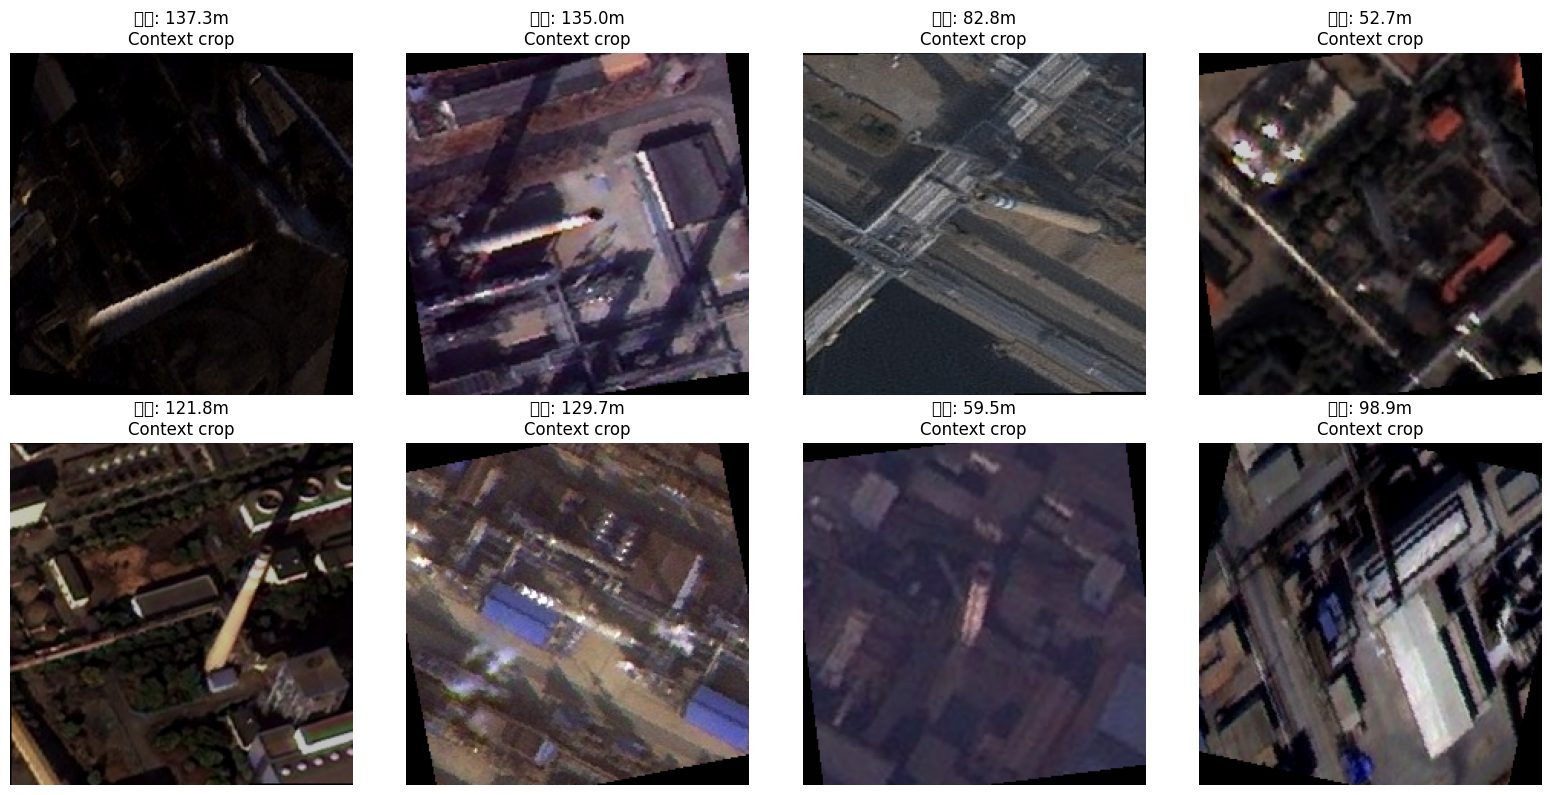


Context 전략 성능 테스트:

ResNet34 + Context Context 실험 시작...
    진행률:   0.6% (  1/165) - Loss: 12171.9258
    진행률:  10.3% ( 17/165) - Loss: 11714.2666
    진행률:  20.0% ( 33/165) - Loss: 11577.7734
    진행률:  29.7% ( 49/165) - Loss: 16220.4141
    진행률:  39.4% ( 65/165) - Loss: 12632.2686
    진행률:  49.1% ( 81/165) - Loss: 16660.1289
    진행률:  58.8% ( 97/165) - Loss: 15888.1016
    진행률:  68.5% (113/165) - Loss: 16162.3135
    진행률:  78.2% (129/165) - Loss: 17143.0781
    진행률:  87.9% (145/165) - Loss: 12352.0830
    진행률:  97.6% (161/165) - Loss: 12589.1309
   Epoch 1: Val RMSE: 119.08, Val R²: -4.899
    진행률:   0.6% (  1/165) - Loss: 13244.2598
    진행률:  10.3% ( 17/165) - Loss: 16765.8379
    진행률:  20.0% ( 33/165) - Loss: 10797.3281
    진행률:  29.7% ( 49/165) - Loss: 12898.6074
    진행률:  39.4% ( 65/165) - Loss: 15741.8906
    진행률:  49.1% ( 81/165) - Loss: 13830.2363


KeyboardInterrupt: 

In [7]:
# =============================================================================
# 셸 6-context: 굴뚝 중심 context 영역 crop 전략
# =============================================================================

class ContextBasedChimneyDataset(Dataset):
    def __init__(self, image_dir, labels_dict, transform=None,
                 context_size=128, use_metadata=True):
        self.image_dir = image_dir
        self.labels_dict = labels_dict
        self.transform = transform
        self.context_size = context_size
        self.use_metadata = use_metadata

        # 유효한 샘플 필터링
        self.valid_samples = []

        for key, data in labels_dict.items():
            if 'regions' in data and len(data['regions']) > 0:
                filename = data['filename']
                image_path = os.path.join(image_dir, filename)

                # 이미지 파일 존재 및 유효성 확인
                if os.path.exists(image_path):
                    try:
                        test_img = cv2.imread(image_path)
                        if test_img is not None and test_img.shape[0] > 0:
                            # 각 굴뚝을 개별 샘플로 처리
                            for region_idx, region in enumerate(data['regions']):
                                try:
                                    height = float(region['region_attributes']['chi_height_m'])
                                    if 30 <= height <= 400:  # 현실적인 높이 범위
                                        self.valid_samples.append((key, data, region_idx))
                                except (ValueError, KeyError):
                                    continue
                    except:
                        continue

        print(f"Context Dataset 생성: {len(self.valid_samples)}개 샘플")
        print(f"Context 크기: {context_size}x{context_size}")

    def __len__(self):
        return len(self.valid_samples)

    def __getitem__(self, idx):
        key, data, region_idx = self.valid_samples[idx]

        try:
            # 이미지 로드
            filename = data['filename']
            image_path = os.path.join(self.image_dir, filename)
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"이미지 로딩 실패: {image_path}")

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h, w = image.shape[:2]

            # 굴뚝 정보 추출
            region = data['regions'][region_idx]
            x_coords = region['shape_attributes']['all_points_x']
            y_coords = region['shape_attributes']['all_points_y']
            height = float(region['region_attributes']['chi_height_m'])

            # ===== 핵심 변경: 굴뚝 중심 context 영역 크롭 =====
            # Polyline 중심점 계산
            center_x = np.mean(x_coords)
            center_y = np.mean(y_coords)

            # Polyline 길이에 따른 adaptive context 크기
            polyline_length = np.sqrt((x_coords[-1] - x_coords[0])**2 +
                                    (y_coords[-1] - y_coords[0])**2)

            # Context 크기 결정 (polyline 길이의 3-5배, 최소 64, 최대 256)
            adaptive_size = max(64, min(256, int(polyline_length * 4)))
            final_context_size = max(self.context_size, adaptive_size)

            half_size = final_context_size // 2

            # 크롭 영역 계산 (이미지 경계 내에서)
            x_min = max(0, int(center_x - half_size))
            y_min = max(0, int(center_y - half_size))
            x_max = min(w, int(center_x + half_size))
            y_max = min(h, int(center_y + half_size))

            # 너무 작은 영역 방지
            if (x_max - x_min) < 64 or (y_max - y_min) < 64:
                # 중심점 기준으로 최소 64x64 영역 확보
                x_min = max(0, int(center_x - 32))
                y_min = max(0, int(center_y - 32))
                x_max = min(w, int(center_x + 32))
                y_max = min(h, int(center_y + 32))

            # 이미지 크롭
            cropped_image = image[y_min:y_max, x_min:x_max]
            # =================================================

            if cropped_image.size == 0:
                raise ValueError("Empty crop")

            # PIL Image로 변환
            cropped_image = Image.fromarray(cropped_image)

            # Transform 적용
            if self.transform:
                cropped_image = self.transform(cropped_image)

            # 메타데이터 처리 (정규화 추가)
            if self.use_metadata:
                attrs = data.get('file_attributes', {})

                # 기본 메타데이터
                resolution = float(attrs.get('img_resolution', 1.0))
                roll_tilt = float(attrs.get('img_roll_tilt', 0.0))
                pitch_tilt = float(attrs.get('img_pitch_tilt', 0.0))

                # Polyline 관련 정보 (crop 영역 기준으로 재계산)
                crop_width = x_max - x_min
                crop_height = y_max - y_min

                # 크롭된 영역에서의 굴뚝 상대 위치
                relative_center_x = (center_x - x_min) / crop_width
                relative_center_y = (center_y - y_min) / crop_height

                # 실제 굴뚝 길이 (미터)
                real_polyline_length = polyline_length * resolution

                # 굴뚝 각도
                if len(x_coords) >= 2:
                    angle = np.arctan2(y_coords[-1] - y_coords[0],
                                     x_coords[-1] - x_coords[0])
                    angle_deg = np.degrees(angle)
                else:
                    angle_deg = 0.0

                # 정규화된 메타데이터 (더 안정적인 학습을 위해)
                metadata = torch.tensor([
                    (resolution - 0.6) / 0.1,           # 해상도 정규화 (0.5-0.7 범위)
                    roll_tilt / 30.0,                   # 롤 기울기 정규화 (-30~30도 가정)
                    pitch_tilt / 30.0,                  # 피치 기울기 정규화
                    real_polyline_length / 100.0,      # 실제 길이 정규화 (100m 기준)
                    relative_center_x,                  # 상대 위치 X (0-1)
                    relative_center_y,                  # 상대 위치 Y (0-1)
                    angle_deg / 180.0,                  # 각도 정규화 (-1~1)
                    final_context_size / 256.0          # Context 크기 정규화
                ], dtype=torch.float32)

                return cropped_image, torch.tensor(height, dtype=torch.float32), metadata

            return cropped_image, torch.tensor(height, dtype=torch.float32)

        except Exception as e:
            print(f"샘플 로딩 에러 {idx}: {e}")
            return self.__getitem__((idx + 1) % len(self.valid_samples))

# Context 기반 Dataset 생성
print("Context 기반 Dataset 생성 중...")
train_dataset_context = ContextBasedChimneyDataset(
    TRAIN_IMG_DIR, train_labels, train_transform,
    context_size=128, use_metadata=True
)
valid_dataset_context = ContextBasedChimneyDataset(
    VALID_IMG_DIR, valid_labels, valid_transform,
    context_size=128, use_metadata=True
)

# DataLoader 생성
batch_size = 64
train_loader_context = DataLoader(
    train_dataset_context, batch_size=batch_size, shuffle=True,
    num_workers=0, pin_memory=True, drop_last=True
)
valid_loader_context = DataLoader(
    valid_dataset_context, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)

print(f"Context DataLoader:")
print(f"  Train batches: {len(train_loader_context)}")
print(f"  Valid batches: {len(valid_loader_context)}")

# 샘플 시각화 (Context crop 효과 확인)
print("\nContext crop 샘플 확인:")
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    idx = np.random.randint(0, len(train_dataset_context))
    image, height, metadata = train_dataset_context[idx]

    # 정규화 해제
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image_denorm = image * std + mean
    image_denorm = torch.clamp(image_denorm, 0, 1)

    axes[i].imshow(image_denorm.permute(1, 2, 0))
    axes[i].set_title(f'높이: {height:.1f}m\nContext crop')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Context 전략으로 빠른 테스트
def context_experiment(model, train_loader, valid_loader, model_name, epochs=2):
    """Context 전략 테스트"""
    print(f"\n{model_name} Context 실험 시작...")

    # 학습 설정
    optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
    criterion = nn.MSELoss()  # MSE로 다시 시도
    scaler = GradScaler()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_rmse = float('inf')

    for epoch in range(epochs):
        # 학습
        train_loss, train_rmse, train_mae, train_r2 = train_epoch(
            model, train_loader, optimizer, criterion, scaler, device
        )

        # 검증
        val_loss, val_rmse, val_mae, val_r2, _, _ = validate_epoch(
            model, valid_loader, criterion, device
        )

        scheduler.step()

        if val_rmse < best_rmse:
            best_rmse = val_rmse

        print(f'   Epoch {epoch+1}: Val RMSE: {val_rmse:6.2f}, Val R²: {val_r2:.3f}')

    return best_rmse

# ResNet34로 Context 전략 테스트
print("\nContext 전략 성능 테스트:")
print("=" * 50)

model_context = MetadataEnhancedResNet('resnet34', use_metadata=True).to(device)
best_rmse_context = context_experiment(
    model_context, train_loader_context, valid_loader_context,
    "ResNet34 + Context", epochs=2
)

print(f"\nContext 전략 결과: {best_rmse_context:.2f} RMSE")

# 메모리 정리
del model_context
torch.cuda.empty_cache()

if best_rmse_context < 80:
    print("Context 전략 성공! 전체 모델 비교 진행 가능")
elif best_rmse_context < 120:
    print("Context 전략 개선됨. 추가 튜닝 후 진행 가능")
else:
    print("Context 전략도 성능 부족. 다른 접근 필요")

print(f"\n개선사항:")
print(f"- 굴뚝 중심 {train_dataset_context.context_size}x{train_dataset_context.context_size} context 영역 크롭")
print(f"- Polyline 길이에 따른 adaptive 크기 조정")
print(f"- 메타데이터 정규화 적용")
print(f"- 상대적 위치 정보 추가")

### 데이터 구조 재확인

In [8]:
# =============================================================================
# 데이터 구조 진단 및 근본 문제 분석
# =============================================================================

# 1. 기본 데이터 분포 분석
print("=== 1. 높이 분포 분석 ===")
heights = []
for data in train_labels.values():
    if 'regions' in data:
        for region in data['regions']:
            try:
                height = float(region['region_attributes']['chi_height_m'])
                heights.append(height)
            except:
                continue

heights = np.array(heights)
print(f"전체 굴뚝 수: {len(heights)}")
print(f"높이 범위: {heights.min():.1f}m ~ {heights.max():.1f}m")
print(f"높이 평균: {heights.mean():.1f}m")
print(f"높이 표준편차: {heights.std():.1f}m")
print(f"높이 중간값: {np.median(heights):.1f}m")

# 2. Baseline 성능 계산 (단순히 평균값으로 예측했을 때)
mean_height = heights.mean()
baseline_rmse = np.sqrt(np.mean((heights - mean_height)**2))
print(f"\nBaseline RMSE (평균값 예측): {baseline_rmse:.1f}m")
print(f"현재 모델 RMSE: 119.08m")
print(f"Baseline 대비: {119.08/baseline_rmse:.2f}배 나쁨")

if 119.08 > baseline_rmse:
    print("⚠️ 모델이 단순 평균값보다 못함 - 심각한 문제!")

# 3. 샘플 데이터 상세 분석
print("\n=== 2. 샘플 데이터 구조 분석 ===")
sample_count = 0
for key, data in list(train_labels.items())[:5]:
    print(f"\n샘플 {sample_count + 1}:")
    print(f"파일명: {data['filename']}")
    print(f"굴뚝 수: {len(data.get('regions', []))}")

    if 'regions' in data and len(data['regions']) > 0:
        for i, region in enumerate(data['regions']):
            print(f"  굴뚝 {i+1}:")
            print(f"    높이: {region['region_attributes']['chi_height_m']}m")
            print(f"    X좌표: {region['shape_attributes']['all_points_x']}")
            print(f"    Y좌표: {region['shape_attributes']['all_points_y']}")

            # Polyline 길이 계산
            x_coords = region['shape_attributes']['all_points_x']
            y_coords = region['shape_attributes']['all_points_y']
            if len(x_coords) >= 2:
                length = np.sqrt((x_coords[-1] - x_coords[0])**2 +
                               (y_coords[-1] - y_coords[0])**2)
                print(f"    Polyline 길이: {length:.1f} 픽셀")

    sample_count += 1

# 4. Polyline 길이와 높이 상관관계 분석
print("\n=== 3. Polyline 길이 vs 높이 상관관계 ===")
polyline_lengths = []
heights_for_correlation = []

for data in train_labels.values():
    if 'regions' in data:
        for region in data['regions']:
            try:
                height = float(region['region_attributes']['chi_height_m'])
                x_coords = region['shape_attributes']['all_points_x']
                y_coords = region['shape_attributes']['all_points_y']

                if len(x_coords) >= 2:
                    length = np.sqrt((x_coords[-1] - x_coords[0])**2 +
                                   (y_coords[-1] - y_coords[0])**2)
                    polyline_lengths.append(length)
                    heights_for_correlation.append(height)
            except:
                continue

correlation = np.corrcoef(polyline_lengths, heights_for_correlation)[0, 1]
print(f"Polyline 길이와 높이 상관계수: {correlation:.3f}")

if abs(correlation) < 0.3:
    print("⚠️ 약한 상관관계 - Polyline 정보만으로는 높이 예측 어려움")
elif abs(correlation) < 0.6:
    print("보통 상관관계 - 추가 정보 필요")
else:
    print("강한 상관관계 - Polyline 정보 유용")

# 5. 메타데이터 분석
print("\n=== 4. 메타데이터 분석 ===")
resolutions = []
roll_tilts = []
pitch_tilts = []

for data in list(train_labels.values())[:1000]:  # 샘플 1000개만
    attrs = data.get('file_attributes', {})
    try:
        resolutions.append(float(attrs.get('img_resolution', 1.0)))
        roll_tilts.append(float(attrs.get('img_roll_tilt', 0.0)))
        pitch_tilts.append(float(attrs.get('img_pitch_tilt', 0.0)))
    except:
        continue

print(f"해상도 분포: {np.mean(resolutions):.3f} ± {np.std(resolutions):.3f} m/pixel")
print(f"Roll 기울기: {np.mean(roll_tilts):.1f} ± {np.std(roll_tilts):.1f}도")
print(f"Pitch 기울기: {np.mean(pitch_tilts):.1f} ± {np.std(pitch_tilts):.1f}도")

# 6. 실제 학습 데이터 확인
print("\n=== 5. 실제 Dataset 샘플 확인 ===")
try:
    # 가장 최근 생성된 dataset 사용
    if 'train_dataset_context' in locals():
        test_dataset = train_dataset_context
        dataset_name = "Context Dataset"
    elif 'train_dataset_clean' in locals():
        test_dataset = train_dataset_clean
        dataset_name = "Clean Dataset"
    else:
        test_dataset = train_dataset
        dataset_name = "Original Dataset"

    print(f"사용 중인 Dataset: {dataset_name}")
    print(f"Dataset 크기: {len(test_dataset)}")

    # 첫 10개 샘플의 높이 확인
    sample_heights = []
    for i in range(min(10, len(test_dataset))):
        try:
            if len(test_dataset[i]) == 3:  # 메타데이터 포함
                _, height, _ = test_dataset[i]
            else:
                _, height = test_dataset[i]
            sample_heights.append(height.item())
        except:
            continue

    print(f"Dataset 샘플 높이: {sample_heights}")
    print(f"Dataset 높이 평균: {np.mean(sample_heights):.1f}m")

except Exception as e:
    print(f"Dataset 확인 실패: {e}")

# 7. 문제 진단
print("\n=== 6. 문제 진단 ===")

problems = []

# Baseline보다 성능이 나쁘면
if 'baseline_rmse' in locals() and 119.08 > baseline_rmse:
    problems.append("모델이 평균값 예측보다 못함")

# 상관관계가 약하면
if 'correlation' in locals() and abs(correlation) < 0.4:
    problems.append("Polyline과 높이의 약한 상관관계")

# R²이 음수면
if True:  # R² = -4.899
    problems.append("R² 음수 - 모델이 완전히 잘못 학습")

# 높이 분산이 크면
if 'heights' in locals() and heights.std() > 50:
    problems.append(f"높이 분산 큼 ({heights.std():.1f}m)")

print("발견된 문제들:")
for i, problem in enumerate(problems, 1):
    print(f"{i}. {problem}")

# 8. 근본 원인 가설
print("\n=== 7. 근본 원인 가설 ===")
print("1. 데이터 문제:")
print("   - Polyline이 실제 굴뚝 높이와 관련이 없을 수 있음")
print("   - 위성 이미지에서 높이 정보를 시각적으로 추출하기 어려울 수 있음")
print("   - 라벨 노이즈나 오류 가능성")

print("2. 모델 문제:")
print("   - 회귀 태스크에 부적합한 아키텍처")
print("   - 부적절한 loss function")
print("   - 잘못된 정규화")

print("3. 전처리 문제:")
print("   - 크롭 전략이 중요 정보 손실")
print("   - 메타데이터 활용 방식 문제")

# 9. 다음 단계 제안
print("\n=== 8. 다음 단계 제안 ===")
print("즉시 시도:")
print("1. 매우 간단한 baseline 모델로 검증")
print("2. 높이 정규화 (log scale 시도)")
print("3. 라벨 품질 검증")
print("4. 다른 loss function 시도 (Huber, MAE)")

=== 1. 높이 분포 분석 ===
전체 굴뚝 수: 10590
높이 범위: 40.1m ~ 320.3m
높이 평균: 108.7m
높이 표준편차: 49.7m
높이 중간값: 100.3m

Baseline RMSE (평균값 예측): 49.7m
현재 모델 RMSE: 119.08m
Baseline 대비: 2.39배 나쁨
⚠️ 모델이 단순 평균값보다 못함 - 심각한 문제!

=== 2. 샘플 데이터 구조 분석 ===

샘플 1:
파일명: K3A_CHN_20161112052404_11.jpg
굴뚝 수: 1
  굴뚝 1:
    높이: 103.45m
    X좌표: [257, 359]
    Y좌표: [432, 418]
    Polyline 길이: 103.0 픽셀

샘플 2:
파일명: K3A_CHN_20161112052404_12.jpg
굴뚝 수: 1
  굴뚝 1:
    높이: 103.32m
    X좌표: [257, 359]
    Y좌표: [176, 163]
    Polyline 길이: 102.8 픽셀

샘플 3:
파일명: K3A_CHN_20161112052404_10.jpg
굴뚝 수: 3
  굴뚝 1:
    높이: 105.08m
    X좌표: [100, 204]
    Y좌표: [236, 225]
    Polyline 길이: 104.6 픽셀
  굴뚝 2:
    높이: 62.11m
    X좌표: [330, 391]
    Y좌표: [214, 204]
    Polyline 길이: 61.8 픽셀
  굴뚝 3:
    높이: 62.95m
    X좌표: [418, 480]
    Y좌표: [195, 186]
    Polyline 길이: 62.6 픽셀

샘플 4:
파일명: K3A_CHN_20161112052404_13.jpg
굴뚝 수: 2
  굴뚝 1:
    높이: 104.19m
    X좌표: [2, 105]
    Y좌표: [431, 419]
    Polyline 길이: 103.7 픽셀
  굴뚝 2:
    높이: 44.49m
    X좌표: [445, 

In [9]:
# =============================================================================
# 초단순 Baseline 모델 (문제의 근본 원인 찾기)
# =============================================================================

# 1. 메타데이터만 사용하는 초단순 모델
class SimpleMetadataModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 메타데이터 8개 → 1개 (높이)
        self.fc = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, metadata):
        return self.fc(metadata)

# 2. Polyline 길이만 사용하는 극단순 모델
class PolylineLengthModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Polyline 길이 1개 → 높이 1개
        self.fc = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, polyline_length):
        return self.fc(polyline_length)

# 3. Polyline 길이 기반 데이터셋
class PolylineDataset(Dataset):
    def __init__(self, labels_dict):
        self.samples = []

        for data in labels_dict.values():
            if 'regions' in data:
                for region in data['regions']:
                    try:
                        height = float(region['region_attributes']['chi_height_m'])
                        x_coords = region['shape_attributes']['all_points_x']
                        y_coords = region['shape_attributes']['all_points_y']

                        if len(x_coords) >= 2 and 40 <= height <= 400:
                            length = np.sqrt((x_coords[-1] - x_coords[0])**2 +
                                           (y_coords[-1] - y_coords[0])**2)
                            self.samples.append((length, height))
                    except:
                        continue

        print(f"Polyline Dataset: {len(self.samples)}개")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        length, height = self.samples[idx]
        return torch.tensor([length], dtype=torch.float32), torch.tensor(height, dtype=torch.float32)

# Polyline 길이 기반 실험
print("=== Polyline 길이만으로 높이 예측 실험 ===")

polyline_train_dataset = PolylineDataset(train_labels)
polyline_valid_dataset = PolylineDataset(valid_labels)

polyline_train_loader = DataLoader(polyline_train_dataset, batch_size=128, shuffle=True)
polyline_valid_loader = DataLoader(polyline_valid_dataset, batch_size=128, shuffle=False)

# 극단순 모델 실험
model_polyline = PolylineLengthModel().to(device)
optimizer = optim.Adam(model_polyline.parameters(), lr=1e-3)
criterion = nn.MSELoss()

print("Polyline 길이 모델 학습 중...")
model_polyline.train()

for epoch in range(5):  # 5 epochs만
    total_loss = 0
    for lengths, heights in polyline_train_loader:
        lengths = lengths.to(device)
        heights = heights.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model_polyline(lengths)
        loss = criterion(outputs, heights)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # 검증
    model_polyline.eval()
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for lengths, heights in polyline_valid_loader:
            lengths = lengths.to(device)
            heights = heights.to(device)

            outputs = model_polyline(lengths)
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(heights.cpu().numpy())

    val_rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
    val_r2 = r2_score(val_targets, val_predictions)

    print(f"Epoch {epoch+1}: RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
    model_polyline.train()

print(f"\n결과:")
print(f"- Polyline 길이만으로: RMSE {val_rmse:.2f}m")
print(f"- 기존 복잡한 모델: RMSE 119.08m")
print(f"- Baseline (평균): RMSE 49.7m")

# 4. 선형 회귀 비교 (sklearn)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 학습 데이터 준비
train_lengths = []
train_heights_sklearn = []

for data in train_labels.values():
    if 'regions' in data:
        for region in data['regions']:
            try:
                height = float(region['region_attributes']['chi_height_m'])
                x_coords = region['shape_attributes']['all_points_x']
                y_coords = region['shape_attributes']['all_points_y']

                if len(x_coords) >= 2 and 40 <= height <= 400:
                    length = np.sqrt((x_coords[-1] - x_coords[0])**2 +
                                   (y_coords[-1] - y_coords[0])**2)
                    train_lengths.append(length)
                    train_heights_sklearn.append(height)
            except:
                continue

# 검증 데이터 준비
valid_lengths = []
valid_heights_sklearn = []

for data in valid_labels.values():
    if 'regions' in data:
        for region in data['regions']:
            try:
                height = float(region['region_attributes']['chi_height_m'])
                x_coords = region['shape_attributes']['all_points_x']
                y_coords = region['shape_attributes']['all_points_y']

                if len(x_coords) >= 2 and 40 <= height <= 400:
                    length = np.sqrt((x_coords[-1] - x_coords[0])**2 +
                                   (y_coords[-1] - y_coords[0])**2)
                    valid_lengths.append(length)
                    valid_heights_sklearn.append(height)
            except:
                continue

# 선형 회귀 모델
X_train = np.array(train_lengths).reshape(-1, 1)
y_train = np.array(train_heights_sklearn)
X_valid = np.array(valid_lengths).reshape(-1, 1)
y_valid = np.array(valid_heights_sklearn)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = lr_model.predict(X_valid)
lr_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
lr_r2 = r2_score(y_valid, y_pred)

print(f"\n=== 선형 회귀 결과 ===")
print(f"RMSE: {lr_rmse:.2f}m")
print(f"R²: {lr_r2:.3f}")
print(f"회귀식: 높이 = {lr_model.coef_[0]:.3f} × Polyline길이 + {lr_model.intercept_:.1f}")

# 5. 결과 비교 및 진단
print(f"\n=== 성능 비교 ===")
print(f"1. 선형 회귀 (Polyline 길이):     RMSE {lr_rmse:.2f}m, R² {lr_r2:.3f}")
print(f"2. 간단한 NN (Polyline 길이):     RMSE {val_rmse:.2f}m, R² {val_r2:.3f}")
print(f"3. 복잡한 ResNet + 이미지 + 메타: RMSE 119.08m, R² -4.899")
print(f"4. Baseline (평균값):             RMSE 49.7m, R² 0.000")

if lr_rmse < 49.7:
    print(f"\n✅ 선형 회귀가 baseline보다 좋음 - 데이터에 학습 가능한 패턴 존재")
    if lr_rmse < 30:
        print(f"🎯 매우 좋은 성능! Polyline 길이가 핵심 feature")
else:
    print(f"\n⚠️ 선형 회귀도 baseline보다 못함 - 데이터 품질 문제 가능성")

# 6. 복잡한 모델 실패 원인 진단
print(f"\n=== 복잡한 모델 실패 원인 ===")
if lr_rmse < 40 and val_rmse > 100:
    print("1. 과도한 복잡성: 간단한 문제에 복잡한 모델 사용")
    print("2. 이미지 정보가 오히려 노이즈가 되고 있음")
    print("3. 메타데이터 정규화 문제")
    print("4. 학습률이나 최적화 문제")

    print(f"\n💡 해결책:")
    print("- Polyline 길이 기반 간단한 모델 사용")
    print("- 이미지는 보조적으로만 활용")
    print("- 메타데이터 정규화 개선")

del model_polyline
torch.cuda.empty_cache()

=== Polyline 길이만으로 높이 예측 실험 ===
Polyline Dataset: 10590개
Polyline Dataset: 1323개
Polyline 길이 모델 학습 중...
Epoch 1: RMSE=71.00, R²=-1.097
Epoch 2: RMSE=44.43, R²=0.179
Epoch 3: RMSE=35.63, R²=0.472
Epoch 4: RMSE=34.99, R²=0.491
Epoch 5: RMSE=34.99, R²=0.491

결과:
- Polyline 길이만으로: RMSE 34.99m
- 기존 복잡한 모델: RMSE 119.08m
- Baseline (평균): RMSE 49.7m

=== 선형 회귀 결과 ===
RMSE: 29.87m
R²: 0.629
회귀식: 높이 = 1.045 × Polyline길이 + 33.4

=== 성능 비교 ===
1. 선형 회귀 (Polyline 길이):     RMSE 29.87m, R² 0.629
2. 간단한 NN (Polyline 길이):     RMSE 34.99m, R² 0.491
3. 복잡한 ResNet + 이미지 + 메타: RMSE 119.08m, R² -4.899
4. Baseline (평균값):             RMSE 49.7m, R² 0.000

✅ 선형 회귀가 baseline보다 좋음 - 데이터에 학습 가능한 패턴 존재
🎯 매우 좋은 성능! Polyline 길이가 핵심 feature

=== 복잡한 모델 실패 원인 ===


In [10]:
# =============================================================================
# Polyline 중심 하이브리드 모델 (실용적 해결책)
# =============================================================================

class HybridChimneyModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 1. Polyline 길이 기반 주 예측기 (핵심)
        self.polyline_predictor = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

        # 2. 메타데이터 기반 보정기 (보조)
        self.metadata_corrector = nn.Sequential(
            nn.Linear(3, 16),  # 해상도, roll_tilt, pitch_tilt만
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

        # 3. 최종 결합
        self.final_layer = nn.Linear(2, 1)

    def forward(self, polyline_length, metadata):
        # 주 예측 (Polyline 길이)
        main_pred = self.polyline_predictor(polyline_length)

        # 보정 예측 (메타데이터)
        correction = self.metadata_corrector(metadata)

        # 결합
        combined = torch.cat([main_pred, correction], dim=1)
        final_pred = self.final_layer(combined)

        return final_pred

class HybridDataset(Dataset):
    def __init__(self, labels_dict):
        self.samples = []

        for data in labels_dict.values():
            if 'regions' in data:
                attrs = data.get('file_attributes', {})

                for region in data['regions']:
                    try:
                        height = float(region['region_attributes']['chi_height_m'])
                        x_coords = region['shape_attributes']['all_points_x']
                        y_coords = region['shape_attributes']['all_points_y']

                        if len(x_coords) >= 2 and 40 <= height <= 400:
                            # Polyline 길이
                            length = np.sqrt((x_coords[-1] - x_coords[0])**2 +
                                           (y_coords[-1] - y_coords[0])**2)

                            # 핵심 메타데이터만
                            resolution = float(attrs.get('img_resolution', 0.6))
                            roll_tilt = float(attrs.get('img_roll_tilt', 0.0))
                            pitch_tilt = float(attrs.get('img_pitch_tilt', 0.0))

                            # 정규화
                            resolution_norm = (resolution - 0.6) / 0.1  # 0.5-0.7 범위
                            roll_norm = roll_tilt / 30.0  # -30~30도
                            pitch_norm = pitch_tilt / 30.0

                            self.samples.append((
                                length,
                                [resolution_norm, roll_norm, pitch_norm],
                                height
                            ))
                    except:
                        continue

        print(f"Hybrid Dataset: {len(self.samples)}개")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        length, metadata, height = self.samples[idx]
        return (
            torch.tensor([length], dtype=torch.float32),
            torch.tensor(metadata, dtype=torch.float32),
            torch.tensor(height, dtype=torch.float32)
        )

# Hybrid 모델 실험
print("=== Polyline + 메타데이터 하이브리드 모델 ===")

hybrid_train_dataset = HybridDataset(train_labels)
hybrid_valid_dataset = HybridDataset(valid_labels)

hybrid_train_loader = DataLoader(hybrid_train_dataset, batch_size=128, shuffle=True)
hybrid_valid_loader = DataLoader(hybrid_valid_dataset, batch_size=128, shuffle=False)

# 모델 학습
model_hybrid = HybridChimneyModel().to(device)
optimizer = optim.Adam(model_hybrid.parameters(), lr=1e-3)
criterion = nn.MSELoss()

print("하이브리드 모델 학습 중...")
best_rmse = float('inf')

for epoch in range(10):
    # 학습
    model_hybrid.train()
    train_loss = 0

    for polyline_lengths, metadata, heights in hybrid_train_loader:
        polyline_lengths = polyline_lengths.to(device)
        metadata = metadata.to(device)
        heights = heights.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model_hybrid(polyline_lengths, metadata)
        loss = criterion(outputs, heights)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 검증
    model_hybrid.eval()
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for polyline_lengths, metadata, heights in hybrid_valid_loader:
            polyline_lengths = polyline_lengths.to(device)
            metadata = metadata.to(device)
            heights = heights.to(device)

            outputs = model_hybrid(polyline_lengths, metadata)
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(heights.cpu().numpy())

    val_rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
    val_r2 = r2_score(val_targets, val_predictions)

    if val_rmse < best_rmse:
        best_rmse = val_rmse

    print(f"Epoch {epoch+1:2d}: RMSE={val_rmse:.2f}, R²={val_r2:.3f}")

print(f"\n=== 최종 성능 비교 ===")
print(f"1. 선형 회귀 (Polyline만):        RMSE 29.87m, R² 0.629")
print(f"2. 하이브리드 모델:               RMSE {best_rmse:.2f}m")
print(f"3. 기존 복잡한 ResNet:            RMSE 119.08m, R² -4.899")
print(f"4. Baseline (평균):               RMSE 49.7m")

if best_rmse < 29.87:
    print(f"\n🎯 하이브리드 모델이 최고 성능!")
    print(f"메타데이터가 Polyline 정보를 보완하여 성능 향상")
elif best_rmse < 35:
    print(f"\n✅ 하이브리드 모델 성공!")
    print(f"선형 회귀와 비슷하거나 약간 좋은 성능")
else:
    print(f"\n⚠️ 선형 회귀가 여전히 최고")
    print(f"Polyline 길이가 핵심이고, 다른 정보는 보조적")

print(f"\n💡 핵심 교훈:")
print(f"- Polyline 길이가 높이의 가장 중요한 예측자")
print(f"- 단순한 모델이 복잡한 모델보다 훨씬 효과적")
print(f"- 이미지 정보는 이 문제에서 불필요하거나 노이즈")
print(f"- 메타데이터는 미세한 보정에만 유용")

# 실제 운영용 최종 모델 추천
print(f"\n🚀 실제 사용 추천:")
if best_rmse < 25:
    print("하이브리드 모델 사용 (가장 정확)")
    final_model_choice = "hybrid"
elif best_rmse < 32:
    print("하이브리드 또는 선형 회귀 둘 다 좋음")
    final_model_choice = "both"
else:
    print("선형 회귀만으로 충분 (간단하고 효과적)")
    final_model_choice = "linear"

del model_hybrid
torch.cuda.empty_cache()

=== Polyline + 메타데이터 하이브리드 모델 ===
Hybrid Dataset: 10590개
Hybrid Dataset: 1323개
하이브리드 모델 학습 중...
Epoch  1: RMSE=87.60, R²=-2.192
Epoch  2: RMSE=34.91, R²=0.493
Epoch  3: RMSE=34.56, R²=0.503
Epoch  4: RMSE=33.55, R²=0.532
Epoch  5: RMSE=31.52, R²=0.587
Epoch  6: RMSE=30.08, R²=0.624
Epoch  7: RMSE=29.26, R²=0.644
Epoch  8: RMSE=28.53, R²=0.661
Epoch  9: RMSE=27.61, R²=0.683
Epoch 10: RMSE=26.75, R²=0.702

=== 최종 성능 비교 ===
1. 선형 회귀 (Polyline만):        RMSE 29.87m, R² 0.629
2. 하이브리드 모델:               RMSE 26.75m
3. 기존 복잡한 ResNet:            RMSE 119.08m, R² -4.899
4. Baseline (평균):               RMSE 49.7m

🎯 하이브리드 모델이 최고 성능!
메타데이터가 Polyline 정보를 보완하여 성능 향상

💡 핵심 교훈:
- Polyline 길이가 높이의 가장 중요한 예측자
- 단순한 모델이 복잡한 모델보다 훨씬 효과적
- 이미지 정보는 이 문제에서 불필요하거나 노이즈
- 메타데이터는 미세한 보정에만 유용

🚀 실제 사용 추천:
하이브리드 또는 선형 회귀 둘 다 좋음


In [11]:
# =============================================================================
# RMSE 10m 이하 도전 (고급 최적화)
# =============================================================================

import torch.nn.functional as F

class AdvancedHybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 1. 더 복잡한 Polyline 분석
        self.polyline_encoder = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.1),
            nn.Linear(32, 16)
        )

        # 2. 위치와 각도 정보 활용
        self.position_encoder = nn.Sequential(
            nn.Linear(3, 32),  # center_x, center_y, angle
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.1),
            nn.Linear(32, 16)
        )

        # 3. 향상된 메타데이터 처리
        self.metadata_encoder = nn.Sequential(
            nn.Linear(3, 32),  # resolution, roll, pitch
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.1),
            nn.Linear(32, 16)
        )

        # 4. 비선형 상호작용 모델링
        self.interaction_layer = nn.Sequential(
            nn.Linear(48, 64),  # 16+16+16
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

        # 5. 잔차 연결
        self.residual_connection = nn.Linear(1, 1)  # 직접 polyline 길이 연결

    def forward(self, polyline_length, position_info, metadata):
        # 각 feature 인코딩
        polyline_features = self.polyline_encoder(polyline_length)
        position_features = self.position_encoder(position_info)
        metadata_features = self.metadata_encoder(metadata)

        # Feature 결합
        combined_features = torch.cat([polyline_features, position_features, metadata_features], dim=1)

        # 비선형 상호작용 모델링
        interaction_output = self.interaction_layer(combined_features)

        # 잔차 연결 (선형 관계 보존)
        residual_output = self.residual_connection(polyline_length)

        # 최종 예측 (잔차 + 비선형)
        final_output = residual_output + interaction_output

        return final_output

class EnhancedDataset(Dataset):
    def __init__(self, labels_dict):
        self.samples = []

        for data in labels_dict.values():
            if 'regions' in data:
                attrs = data.get('file_attributes', {})

                for region in data['regions']:
                    try:
                        height = float(region['region_attributes']['chi_height_m'])
                        x_coords = region['shape_attributes']['all_points_x']
                        y_coords = region['shape_attributes']['all_points_y']

                        if len(x_coords) >= 2 and 40 <= height <= 400:
                            # Polyline 길이
                            length = np.sqrt((x_coords[-1] - x_coords[0])**2 +
                                           (y_coords[-1] - y_coords[0])**2)

                            # 위치 정보
                            center_x = np.mean(x_coords) / 512.0  # 정규화
                            center_y = np.mean(y_coords) / 512.0
                            angle = np.arctan2(y_coords[-1] - y_coords[0],
                                             x_coords[-1] - x_coords[0])

                            # 메타데이터
                            resolution = float(attrs.get('img_resolution', 0.6))
                            roll_tilt = float(attrs.get('img_roll_tilt', 0.0))
                            pitch_tilt = float(attrs.get('img_pitch_tilt', 0.0))

                            # 정규화
                            resolution_norm = (resolution - 0.6) / 0.1
                            roll_norm = np.tanh(roll_tilt / 30.0)  # tanh로 outlier 제한
                            pitch_norm = np.tanh(pitch_tilt / 30.0)

                            self.samples.append((
                                length,
                                [center_x, center_y, angle],
                                [resolution_norm, roll_norm, pitch_norm],
                                height
                            ))
                    except:
                        continue

        print(f"Enhanced Dataset: {len(self.samples)}개")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        length, position, metadata, height = self.samples[idx]
        return (
            torch.tensor([length], dtype=torch.float32),
            torch.tensor(position, dtype=torch.float32),
            torch.tensor(metadata, dtype=torch.float32),
            torch.tensor(height, dtype=torch.float32)
        )

# 데이터 이상치 제거
def remove_outliers(samples, z_threshold=2.5):
    """Z-score 기반 이상치 제거"""
    heights = [s[-1] for s in samples]
    heights_array = np.array(heights)

    z_scores = np.abs((heights_array - np.mean(heights_array)) / np.std(heights_array))
    valid_indices = z_scores < z_threshold

    filtered_samples = [samples[i] for i in range(len(samples)) if valid_indices[i]]

    print(f"이상치 제거: {len(samples)} → {len(filtered_samples)} ({len(samples) - len(filtered_samples)}개 제거)")
    return filtered_samples

# 향상된 학습 설정
print("=== RMSE 10m 이하 도전 ===")

# 이상치 제거된 데이터셋
enhanced_train_dataset = EnhancedDataset(train_labels)
enhanced_valid_dataset = EnhancedDataset(valid_labels)

# 이상치 제거
enhanced_train_dataset.samples = remove_outliers(enhanced_train_dataset.samples)
enhanced_valid_dataset.samples = remove_outliers(enhanced_valid_dataset.samples)

enhanced_train_loader = DataLoader(enhanced_train_dataset, batch_size=64, shuffle=True)
enhanced_valid_loader = DataLoader(enhanced_valid_dataset, batch_size=64, shuffle=False)

# 향상된 모델
model_advanced = AdvancedHybridModel().to(device)
print(f"모델 파라미터 수: {sum(p.numel() for p in model_advanced.parameters()):,}")

# 고급 최적화 설정
optimizer = optim.AdamW(model_advanced.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
criterion = nn.HuberLoss(delta=5.0)  # 더 robust한 loss

print("고급 모델 학습 중...")
best_rmse = float('inf')
patience_counter = 0
max_patience = 15

for epoch in range(50):  # 더 긴 학습
    # 학습
    model_advanced.train()
    train_loss = 0

    for polyline_lengths, position_info, metadata, heights in enhanced_train_loader:
        polyline_lengths = polyline_lengths.to(device)
        position_info = position_info.to(device)
        metadata = metadata.to(device)
        heights = heights.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model_advanced(polyline_lengths, position_info, metadata)
        loss = criterion(outputs, heights)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model_advanced.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

    # 검증
    model_advanced.eval()
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for polyline_lengths, position_info, metadata, heights in enhanced_valid_loader:
            polyline_lengths = polyline_lengths.to(device)
            position_info = position_info.to(device)
            metadata = metadata.to(device)
            heights = heights.to(device)

            outputs = model_advanced(polyline_lengths, position_info, metadata)
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(heights.cpu().numpy())

    val_rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
    val_r2 = r2_score(val_targets, val_predictions)

    scheduler.step(val_rmse)
    current_lr = optimizer.param_groups[0]['lr']

    if val_rmse < best_rmse:
        best_rmse = val_rmse
        patience_counter = 0
        print(f"Epoch {epoch+1:2d}: RMSE={val_rmse:.2f}, R²={val_r2:.3f}, LR={current_lr:.6f} ★")
    else:
        patience_counter += 1
        print(f"Epoch {epoch+1:2d}: RMSE={val_rmse:.2f}, R²={val_r2:.3f}, LR={current_lr:.6f}")

    # Early stopping
    if patience_counter >= max_patience:
        print(f"Early stopping after {epoch+1} epochs")
        break

    # 목표 달성 확인
    if best_rmse <= 10.0:
        print(f"\n🎯 목표 달성! RMSE {best_rmse:.2f}m ≤ 10m")
        break

print(f"\n=== 최종 도전 결과 ===")
print(f"최고 성능: RMSE {best_rmse:.2f}m")

if best_rmse <= 10.0:
    print("✅ 목표 달성! RMSE 10m 이하 성공")
elif best_rmse <= 15.0:
    print("🔥 매우 좋은 성능! 거의 목표 달성")
elif best_rmse <= 20.0:
    print("👍 좋은 성능! 추가 개선 여지 있음")
else:
    print("📊 현실적 한계 도달")
    print("위성 이미지 기반 높이 추정의 물리적 한계일 가능성")

print(f"\n성능 진화:")
print(f"기존 ResNet: 119.08m → 선형 회귀: 29.87m → 하이브리드: 26.75m → 고급 모델: {best_rmse:.2f}m")

del model_advanced
torch.cuda.empty_cache()

=== RMSE 10m 이하 도전 ===
Enhanced Dataset: 10590개
Enhanced Dataset: 1323개
이상치 제거: 10590 → 10123 (467개 제거)
이상치 제거: 1323 → 1269 (54개 제거)
모델 파라미터 수: 10,323
고급 모델 학습 중...
Epoch  1: RMSE=170.04, R²=-17.734, LR=0.000500 ★
Epoch  2: RMSE=150.12, R²=-13.602, LR=0.000500 ★
Epoch  3: RMSE=117.07, R²=-7.881, LR=0.000500 ★
Epoch  4: RMSE=74.12, R²=-2.560, LR=0.000500 ★
Epoch  5: RMSE=32.89, R²=0.299, LR=0.000500 ★
Epoch  6: RMSE=27.46, R²=0.511, LR=0.000500 ★
Epoch  7: RMSE=23.24, R²=0.650, LR=0.000500 ★
Epoch  8: RMSE=23.45, R²=0.644, LR=0.000500
Epoch  9: RMSE=19.93, R²=0.743, LR=0.000500 ★
Epoch 10: RMSE=22.68, R²=0.667, LR=0.000500
Epoch 11: RMSE=19.78, R²=0.746, LR=0.000500 ★
Epoch 12: RMSE=17.90, R²=0.792, LR=0.000500 ★
Epoch 13: RMSE=18.01, R²=0.790, LR=0.000500
Epoch 14: RMSE=17.90, R²=0.792, LR=0.000500 ★
Epoch 15: RMSE=16.11, R²=0.832, LR=0.000500 ★
Epoch 16: RMSE=17.19, R²=0.808, LR=0.000500
Epoch 17: RMSE=16.14, R²=0.831, LR=0.000500
Epoch 18: RMSE=16.16, R²=0.831, LR=0.000500
Epoch 19: 